# **Reduced Order Methods: an Introduction**

In this Lab we are going to introduce the main aspects of a parametric problem and the features that allow us to deal with it by means of Reduced Order Methods (ROMs).

First of all: ROMs are based on a Full Order Model (FOM). We can say also High Fidelity (HF) simulation.

Thus, we **need** a *standard* solver based on *standard discretizations*: in out case linear FE solvers.

Let us import the FOM library!

In [1]:
!git clone https://github.com/fvicini/CppToPython.git
%cd CppToPython

Cloning into 'CppToPython'...
remote: Enumerating objects: 600, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 600 (delta 13), reused 24 (delta 7), pack-reused 487
Receiving objects: 100% (600/600), 424.27 KiB | 2.19 MiB/s, done.
Resolving deltas: 100% (406/406), done.
/content/CppToPython


In [2]:
!git submodule init
!git submodule update

Submodule 'gedim' (https://github.com/fvicini/gedim.git) registered for path 'gedim'
Cloning into '/content/CppToPython/gedim'...
Submodule path 'gedim': checked out 'c52847f1a527d36b529f39d3744afe9fd612b62c'


In [3]:
!mkdir -p externals
%cd externals
!cmake -DINSTALL_VTK=OFF -DINSTALL_LAPACK=OFF ../gedim/3rd_party_libraries
!make -j4
%cd ..

/content/CppToPython/externals
-- The CXX compiler identification is GNU 9.4.0
-- The C compiler identification is GNU 9.4.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Install Eigen3 release 3.4.0
-- Install GoogleTest release 1.11.0
-- Install triangle release 1.0.4
-- Install tetgen release 1.0.0
-- Configuring done
-- Generating done
-- Build files have been written to: /content/CppToPython/externals
[  3%] Creating directories for 'Eigen'
[  6%] Creating directories for 'triangle'
[  9%] Creating directories for 'googletest'
[ 12%] Creating directories for 'tetgen'
[ 15%] Performing download step (git clone) for 'triang

In [4]:
!mkdir -p release
%cd release 
!cmake -DCMAKE_PREFIX_PATH="/content/CppToPython/externals/Main_Install/eigen3;/content/CppToPython/externals/Main_Install/triangle;/content/CppToPython/externals/Main_Install/tetgen;/content/CppToPython/externals/Main_Install/googletest" ../
!make -j4 GeDiM4Py
%cd ..

/content/CppToPython/release
-- The CXX compiler identification is GNU 9.4.0
-- The C compiler identification is GNU 9.4.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Gedim Build configuration: Release
-- Gedim Library will be installed in: /content/CppToPython/release/gedim/GeDiM/GeDiM
-- Looking for sgemm_
-- Looking for sgemm_ - not found
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Failed
-- Looking for pthread_create in pthreads
-- Looking for pthread_create in pthreads - not found
-- Looking for pthread_create in pthread
-- Looking for pthread_create in pthread - found
-- Foun

In [5]:
import numpy as np
import GeDiM4Py as gedim

In [6]:
lib = gedim.ImportLibrary("./release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

## The parametric version of the heat conductivity equation

Solve the following equation on square ${\Omega} = (-1, +1) \times (-1, +1)$

$$
\begin{cases}
\nabla \cdot (k_{\mu} \nabla u) = 0 & \text{in } \Omega\\
k_{\mu} \nabla u \cdot n_1 = \mu_2 & \text{in } \Gamma_{base}\\
u = 0 & \text{in } \Gamma_{top}\\
k_{\mu} \nabla u \cdot n_2 = 0 & \text{otherwise} 
\end{cases}
$$

where $k_{\mu} = \mu_1$ if $x^2 + y^2 \leq R^2$ and $k = 1$ otherwise. 
The parametric space is $\mathcal P = [0.1, 10] \times [-1,1]$.

<img src="https://drive.google.com/uc?id=1j98eKPtRy8IqsLMKkue2dINRy6yNS20j"
 style="float:center;width:50px;height:50px;" align="center">


The parameter $\boldsymbol \mu \in \mathcal P$ is physical and changes the features of the flow: 

1. $\mu_1$ the conductivity in $\Omega_1$;
2. $\mu_2$ describes the heat flux in the bottom part of the boundary.

First thing: we define two subdomains $\Omega_1$ and $\Omega_2$, such that
1. $\Omega_1$ is a disk in the origin with radius $r_0=0.5$, and
2. $\Omega_2=\Omega/\ \overline{\Omega_1}$.
3. $\Gamma_{base}$ to define where we will change the heat flux.

For a more exhaustive description of the problem refer to [this tutorial](https://colab.research.google.com/github/RBniCS/RBniCS/blob/open-in-colab/tutorials/01_thermal_block/tutorial_thermal_block.ipynb) based on [RBniCS library](https://www.rbnicsproject.org/).





In [7]:
def Heat_R():
	return 0.5


def Omega1(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.ones(numPoints)
	for p in range(0, numPoints):
		if (matPoints[0,p] * matPoints[0,p] + matPoints[1,p] * matPoints[1,p]) > (Heat_R() * Heat_R() + 1.0e-16):
			values[p] = 0.
	return values.ctypes.data

def Omega2(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.ones(numPoints)
	for p in range(0, numPoints):
		if (matPoints[0,p] * matPoints[0,p] + matPoints[1,p] * matPoints[1,p]) <= (Heat_R() * Heat_R() + 1.0e-16):
			values[p] = 0. 
	return values.ctypes.data

def Gamma_base(numPoints, points):
	values = np.ones(numPoints)
	return values.ctypes.data

**Define High Fidelity Simulation Parameters**:
for a parametric problem we need not only the order of the discretization, but also the parametric space definition.



In [8]:
order = 2
mu1_range = [0.1, 10.]
mu2_range = [-1., 1.]

### Import Mesh

In [9]:
%%writefile ImportMesh.csv
InputFolderPath
./Meshes/Mesh1

Overwriting ImportMesh.csv


In [10]:
[meshInfo, mesh] = gedim.ImportDomainMesh2D(lib)

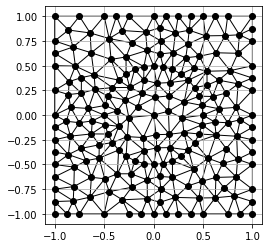

In [11]:
gedim.PlotMesh(mesh)

**Create Discrete Space FEM (the FOM approximation)**

In [12]:
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 3, 3, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

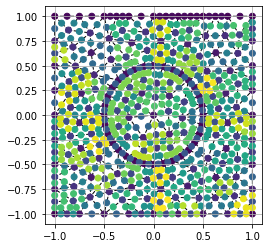

In [13]:
gedim.PlotDofs(mesh, dofs, strongs)

### **Assemble linear system exploting affinity**

To have a better understanding of the _affine decomposition_ let us define the _weak formulation_ of the problem:
given $\boldsymbol \mu \in matcal P$, find the solution $u(\boldsymbol \mu)$ that solves


$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space is
$$
\mathbb{V} = \{v\in H^1(\Omega) : v|_{\Gamma_{top}}=0\},
$$
* the bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is 
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \kappa_\mu \nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized forcing term $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is
$$f(v; \boldsymbol{\mu})= \mu_1\int_{\Gamma_{base}}v \ ds.$$

We want to compute the solution for **many** parameters in the parametric space.

Looking at the problem at hand, we notice that the system is _affine_!

Namely, it can be written as 
$$
\sum_{i=1}^{q_a} \theta_i^a(\boldsymbol \mu)a_i(u,v) = \sum_{i=0}^{q_f} \theta_i^f(\boldsymbol \mu)f_i(v),
$$
for $\theta_i^a(\boldsymbol \mu)$ and $\theta_i^f(\boldsymbol \mu)$ real functions and $q_a, q_f \in \mathbb N$. 


The separation of variables, i.e. $\boldsymbol \mu-$dependent and $\boldsymbol \mu-$independent quantities, is really useful to divide the ROM process under the _offline_-_online_ paradigm (more details in the next Lab).

For now, let us focus on the FOM parametric version. Our problem is affine-decomposed in

$$a(u,v;\boldsymbol{\mu})=\underbrace{\mu_1}_{\Theta^{a}_1(\boldsymbol{\mu})}\underbrace{\int_{\Omega_1}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_1(u,v)} \ + \  \underbrace{1}_{\Theta^{a}_2(\boldsymbol{\mu})}\underbrace{\int_{\Omega_2}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_2(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{\mu_2}_{\Theta^{f}_1(\boldsymbol{\mu})} \underbrace{\int_{\Gamma_{base}}v \ ds}_{f_1(v)}.$$




Let us define $\theta_i^a(\boldsymbol \mu)$ and $\theta_1^f(\boldsymbol \mu)$, for $i \in \{1,2\}$ with some numbers in the parametric range. 

In [14]:
thetaA1 = 1.
thetaA2 = 6.68
thetaf1 = 0.94

Let us define $a_1(u,v)$, $a_2(u,v)$ and $f(v)$,

In [15]:

[stiffness1, stiffnessStrong1] = gedim.AssembleStiffnessMatrix(Omega2, problemData, lib)
[stiffness2, stiffnessStrong2] = gedim.AssembleStiffnessMatrix(Omega1, problemData, lib)
	
weakTerm_down1 = gedim.AssembleWeakTerm(Gamma_base, 1, problemData, lib)




and, finally, let us solve $a(u,v; \boldsymbol \mu) = f(v; \boldsymbol \mu)$.

In [16]:
a_mu = thetaA1*stiffness1 + thetaA2*stiffness2
f_mu = thetaf1*weakTerm_down1

In [17]:
solution = gedim.LUSolver(a_mu, f_mu, lib)

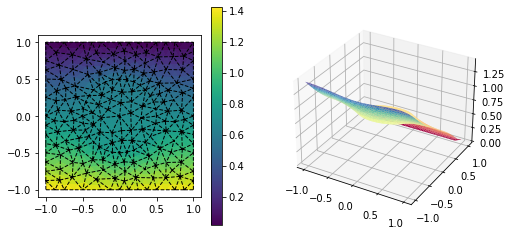

In [18]:
gedim.PlotSolution(mesh, dofs, strongs, solution, np.zeros(problemData['NumberStrongs']))

## **Let us do another exercise together** ##

Solve the following equation on square ${\Omega} = (-1, +1) \times (-1, +1)$

$$
\begin{cases}
\nabla \cdot (k_{\mu} \nabla u) + \beta_\mu x(1-x) \frac {\partial}{\partial x}u = f & \text{in } \Omega\\
u = 0 & \text{in } \Gamma_{top}\\
k_{\mu} \nabla u \cdot n_2 = 0 & \text{otherwise} 
\end{cases}
$$

where $k_\mu = \mu_i \in \Omega_i$ and $\beta_\mu = \mu_{1 + i} \in \Omega_i$ for $i \in \{1, \dots, 4\}$
The parametric space is $\mathcal P = [0.1, 5]^4 \times [1, 10]^4$.

<img src="https://drive.google.com/uc?id=1aFusZvSGlO6wDFXCjyq7zp4lsIycw2ac"
 style="float:center;width:1px;height:1px;" align="center" width="300">








Let us define the nodes of the boundary and the subdomains.

In [19]:
def Poisson_strongTerm(numPoints, points):
	......
	return values.ctypes.data

def Poisson_f(numPoints, points):
	.......
	return values.ctypes.data

######## subdomains

Also in this case we have an affine decomposition:

$$a(u,v;\boldsymbol{\mu})=
\sum_{i = 1}^4 \underbrace{\mu_i}_{\Theta^{a}_i(\boldsymbol{\mu}) \text{ for } i \in \{1, \dots, 4\}}\underbrace{\int_{\Omega_i}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_i(u,v) \text{ for } i \in \{5, \dots, 8\}} \ + \sum_{i = 1}^4 \underbrace{\mu_i}_{\Theta^{a}_i(\boldsymbol{\mu}) \text{ for } i \in \{5, \dots, 8\}}\underbrace{\int_{\Omega_i}x(1-x)\frac{\partial}{\partial x} u \cdot v \ d\boldsymbol{x}}_{a_i(u,v) \text{ for } i \in \{1, \dots, 4\}}$$
$$f(v; \boldsymbol{\mu}) = \underbrace{10}_{\Theta^{f}_1(\boldsymbol{\mu})} \underbrace{\int_{\Omega}v \ ds}_{f_1(v)}.$$

Let us define the bilinear forms and the forcing term.

In [37]:
### mu-independent quantities


Let us define the ``thetas``.

In [32]:
#thetas


In [33]:
### lhs
 
lhs = stiffness + advection

In [34]:
#rhs

rhs = forcingTerm - (stiffnessStrong + advectionStrong ) @ solutionStrong #

Finally, let us solve the system.

In [ ]:
solution = gedim.LUSolver(lhs, rhs, lib)


In [ ]:
gedim.PlotSolution(mesh, dofs, strongs, solution, solutionStrong)